<a href="https://colab.research.google.com/github/argareeva/DataAnalyticsProject/blob/main/%D0%9E%D0%9A%D0%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 5.7 MB/s eta 0:00:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Прекурсор     10 non-null     int64  
 1   Растворитель  10 non-null     int64  
 2   t, C          10 non-null     int64  
 3   t, ч          10 non-null     int64  
 4   pH            10 non-null     float64
 5   HNO3          10 non-null     int64  
 6   CH3COOH       10 non-null     int64  
 7   HCl           10 non-null     int64  
 8   H2SO4         10 non-null     int64  
 9   t1, C         10 non-null     float64
 10  H1, Дж/г      10 non-null     float64
 11  t2, C         10 non-null     float64
 12  H2, Дж/г      10 non-null     float64
 13  D(842), нм    8 non-null      float64
dtypes: float64(6), int64(8)
memory usage: 1.2 KB
None
       Прекурсор  Растворитель        t, C       t, ч         pH       HNO3  \
count  10.000000     10.000000   10.000000  10.000000  10.000000  10.000000 

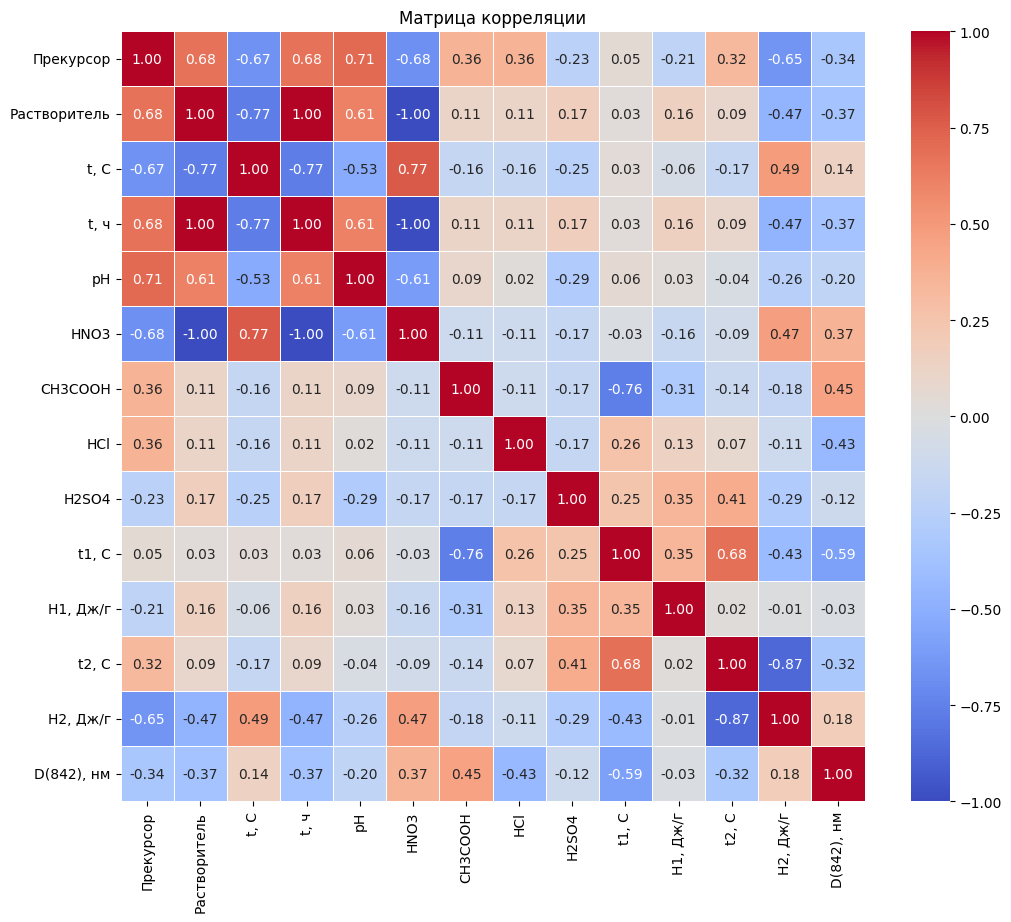

In [175]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('Book3.csv', delimiter=';')

data_numeric = data.drop(columns=['Фазовый состав', 'A1(C)', 'A2(C)', 'A1(O)', 'A2(O)', 'A1(Fe)', 'A2(Fe)'])

print(data_numeric.info())
print(data_numeric.describe())

correlation_matrix = data_numeric.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Матрица корреляции')
plt.show()

In [176]:
data_numeric = data_numeric.dropna(subset='D(842), нм')

data_numeric.head(10)

,Прекурсор,Растворитель,"t, C","t, ч",pH,HNO3,CH3COOH,HCl,H2SO4,"t1, C","H1, Дж/г","t2, C","H2, Дж/г","D(842), нм"
0,11,21,150,8,1.5,31,0,0,0,115.4,540.8,420.2,-20.32,33.4
1,12,22,24,24,6.0,0,0,0,0,114.7,547.4,417.8,-24.07,37.8
2,12,22,24,24,5.0,0,0,0,0,113.5,550.3,415.3,-19.48,21.3
3,13,22,24,24,5.7,0,31,0,0,110.8,535.8,419.7,-28.20,35.1
5,13,22,24,24,5.7,0,0,0,0,116.8,520.4,425.1,-30.30,19.7
6,13,22,24,24,5.3,0,0,31,0,117.2,550.3,421.8,-27.40,17.9
8,12,22,24,24,5.5,0,0,0,31,115.3,545.6,420.3,-24.27,24.0
9,12,22,120,24,5.0,0,0,0,0,116.1,549.7,419.6,-24.26,21.2


In [223]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X = data_numeric.drop(columns=['D(842), нм', 'H2SO4', 'HNO3', 'pH', 'H1, Дж/г', 'H2, Дж/г', 'HCl', 't, ч', 't1, C'])
y = data_numeric['D(842), нм']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAE (Linear Regression): {mae:.4}')
print(f'MSE (Linear Regression): {mse:.4}')
print(f'R^2 (Linear Regression): {r2:.4}')

feature_weights = pd.DataFrame({'Feature': X.columns, 'Weight': lr_model.coef_})
print(feature_weights)

MAE (Linear Regression): 5.038
MSE (Linear Regression): 60.49
R^2 (Linear Regression): 0.1128
        Feature        Weight
0     Прекурсор -6.892000e+00
1  Растворитель -1.115774e-14
2          t, C  0.000000e+00
3       CH3COOH  5.908387e-01
4         t2, C  5.400000e-01


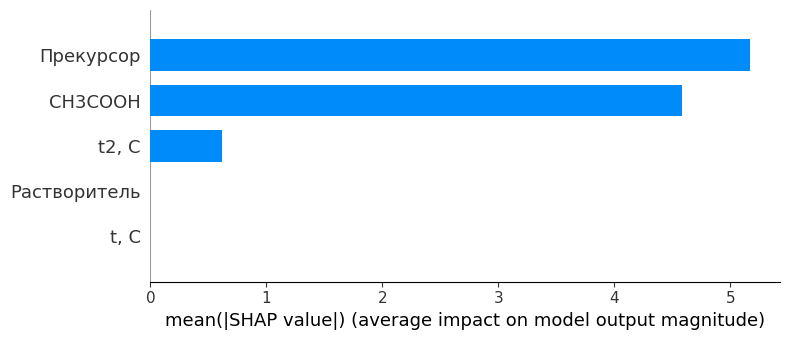

In [224]:
import shap

explainer_lr = shap.LinearExplainer(lr_model, X_train)
shap_values_lr = explainer_lr(X_test)
shap.summary_plot(explainer_lr.shap_values(X_test), X_test, plot_type="bar", feature_names=X_test.columns)

In [227]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor

X = data_numeric.drop(columns=['D(842), нм', 'H2SO4', 'HNO3', 'pH', 'H1, Дж/г', 'H2, Дж/г'])
y = data_numeric['D(842), нм']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt_model = DecisionTreeRegressor(max_depth=3, min_samples_leaf=1, min_samples_split=1)

param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_dt = GridSearchCV(dt_model, param_grid, cv=4, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search_dt.fit(X_train, y_train)

print("Оптимальные параметры:", grid_search_dt.best_params_)

cv_scores = cross_val_score(grid_search_dt.best_estimator_, X_train, y_train, cv=4, scoring='neg_mean_squared_error')
print(f'Среднее значение MSE на кросс-валидации: {-cv_scores.mean():.4}')

y_pred_dt = grid_search_dt.best_estimator_.predict(X_test)

mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print(f'MAE (Decision Tree): {mae_dt:.4}')
print(f'MSE (Decision Tree): {mse_dt:.4}')
print(f'R^2 (Decision Tree): {r2_dt:.4}')

Оптимальные параметры: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5}
Среднее значение MSE на кросс-валидации: 54.91
MAE (Decision Tree): 5.95
MSE (Decision Tree): 46.96
R^2 (Decision Tree): 0.5256


In [180]:
from sklearn.tree import DecisionTreeRegressor

dt_model_tuned = DecisionTreeRegressor(max_depth=3, min_samples_leaf=2, min_samples_split=5, random_state=42)
dt_model_tuned.fit(X_train, y_train)

y_pred_dt_tuned = dt_model_tuned.predict(X_test)

mae_dt_tuned = mean_absolute_error(y_test, y_pred_dt_tuned)
mse_dt_tuned = mean_squared_error(y_test, y_pred_dt_tuned)
r2_dt_tuned = r2_score(y_test, y_pred_dt_tuned)

print(f'MAE (Tuned Decision Tree): {mae_dt_tuned:.4}')
print(f'MSE (Tuned Decision Tree): {mse_dt_tuned:.4}')
print(f'R^2 (Tuned Decision Tree): {r2_dt_tuned:.4}')

feature_weights = pd.DataFrame({'Feature': X.columns, 'Weight': dt_model_tuned.feature_importances_})
print(feature_weights)

MAE (Tuned Decision Tree): 5.95
MSE (Tuned Decision Tree): 46.96
R^2 (Tuned Decision Tree): 0.5256
        Feature  Weight
0     Прекурсор     0.0
1  Растворитель     0.0
2          t, C     0.0
3          t, ч     0.0
4       CH3COOH     0.0
5           HCl     0.0
6         t1, C     1.0
7         t2, C     0.0


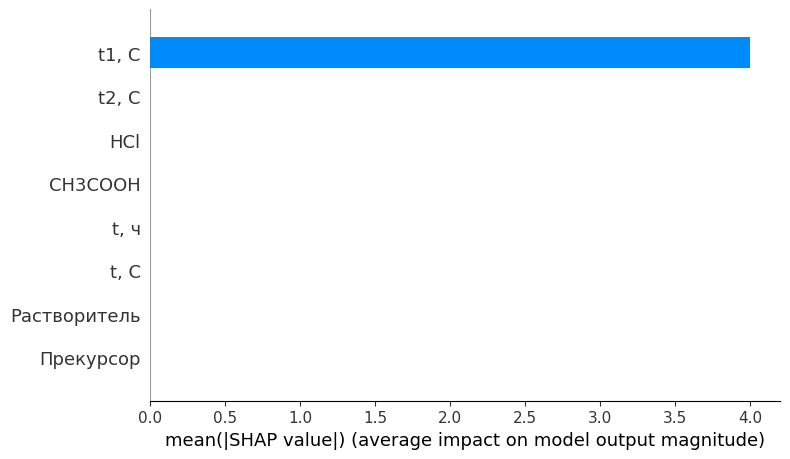

In [181]:
import shap

explainer_xgboost = shap.Explainer(dt_model_tuned)
shap_values_xgboost = explainer_xgboost(X_test)
shap.summary_plot(explainer_xgboost.shap_values(X_test), X_test, plot_type="bar", feature_names=X_test.columns)

In [214]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

X = data_numeric.drop(columns=['D(842), нм', 'Растворитель', 'HCl', 'H2SO4', 'HNO3', 'pH', 'H1, Дж/г', 'H2, Дж/г'])
y = data_numeric['D(842), нм']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor()

param_grid = {
    'n_estimators': [3, 5, 10],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(rf_model, param_grid, cv=4, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search_rf.fit(X_train, y_train)

print("Оптимальные параметры:", grid_search_rf.best_params_)

y_pred_rf = grid_search_rf.best_estimator_.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'MAE (Random Forest): {mae_rf:.4}')
print(f'MSE (Random Forest): {mse_rf:.4}')
print(f'R^2 (Random Forest): {r2_rf:.4}')

Оптимальные параметры: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 5}
MAE (Random Forest): 8.043
MSE (Random Forest): 67.96
R^2 (Random Forest): 0.3136


In [216]:
from sklearn.ensemble import RandomForestRegressor

rf_model_tuned = RandomForestRegressor(n_estimators=5, max_depth=5, min_samples_leaf=2, min_samples_split=2, random_state=42)
rf_model_tuned.fit(X_train, y_train)

y_pred_rf_tuned = rf_model_tuned.predict(X_test)

mae_rf_tuned = mean_absolute_error(y_test, y_pred_rf_tuned)
mse_rf_tuned = mean_squared_error(y_test, y_pred_rf_tuned)
r2_rf_tuned = r2_score(y_test, y_pred_rf_tuned)

print(f'MAE (Tuned Random Forest): {mae_rf_tuned:.4}')
print(f'MSE (Tuned Random Forest): {mse_rf_tuned:.4}')
print(f'R^2 (Tuned Random Forest): {r2_rf_tuned:.4}')

feature_weights = pd.DataFrame({'Feature': X.columns, 'Weight': rf_model_tuned.feature_importances_})
print(feature_weights)

MAE (Tuned Random Forest): 11.53
MSE (Tuned Random Forest): 143.5
R^2 (Tuned Random Forest): -0.4492
     Feature  Weight
0  Прекурсор     0.2
1       t, C     0.0
2       t, ч     0.0
3    CH3COOH     0.0
4      t1, C     0.4
5      t2, C     0.4


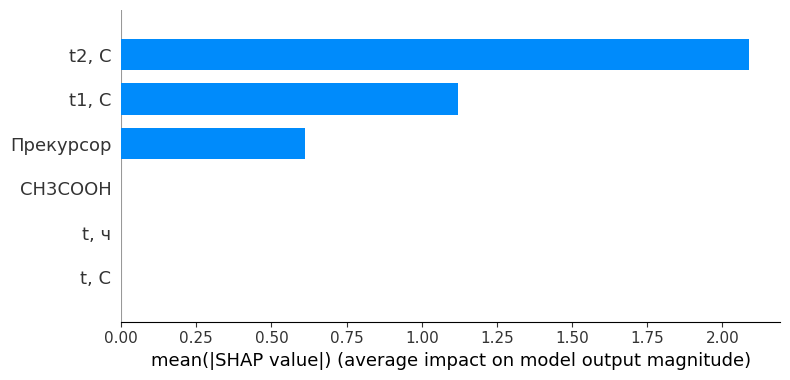

In [217]:
import shap

explainer_xgboost = shap.Explainer(rf_model_tuned)
shap_values_xgboost = explainer_xgboost(X_test)
shap.summary_plot(explainer_xgboost.shap_values(X_test), X_test, plot_type="bar", feature_names=X_test.columns)

In [185]:
!pip install xgboost

In [186]:
from xgboost import XGBRegressor

X = data_numeric.drop(columns=['D(842), нм', 'H2SO4', 'HNO3', 'pH', 'H1, Дж/г', 'H2, Дж/г'])
y = data_numeric['D(842), нм']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

xgboost_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgboost_model.fit(X_train, y_train)

xgboost_y_pred = xgboost_model.predict(X_test)
xgboost_mae = mean_absolute_error(y_test, xgboost_y_pred)
xgboost_mse = mean_squared_error(y_test, xgboost_y_pred)
xgboost_r2 = r2_score(y_test, xgboost_y_pred)

print(f'MAE (XGBoost): {xgboost_mae:.4}')
print(f'MSE (XGBoost): {xgboost_mse:.4}')
print(f'R^2 (XGBoost): {xgboost_r2:.4}\n')

MAE (XGBoost): 7.625
MSE (XGBoost): 92.92
R^2 (XGBoost): -0.3628



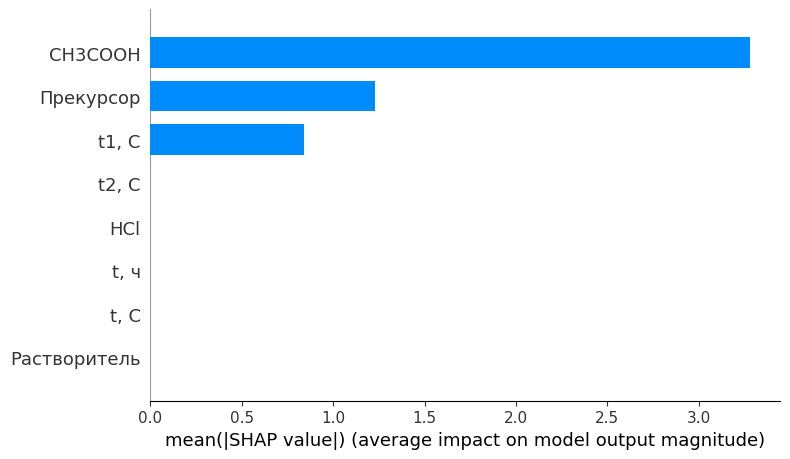

In [187]:
import shap

explainer_xgboost = shap.Explainer(xgboost_model)

shap_values_xgboost = explainer_xgboost(X_test)

shap.summary_plot(explainer_xgboost.shap_values(X_test), X_test, plot_type="bar", feature_names=X_test.columns)